<a href="https://colab.research.google.com/github/nalsadi/UKFNeuralNet/blob/master/UKFNNREDO2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UKF Optimization for a Neural Network

Note: This is a filterpy implementation

### Three Core Components:
1. Install Libs

2. The UKF Library

3. The UKF Implementation 

## Install Requirements 

In [45]:
!pip install filterpy

## Setting Up the Library and Globals

In [44]:
from pprint import pformat
import numpy as np
import matplotlib.pyplot as plt
import collections
import logging
from filterpy.kalman import KalmanFilter, UnscentedKalmanFilter, MerweScaledSigmaPoints, unscented_transform
from keras.models import Sequential
from keras.layers import Dense, Dropout
import math, os, time, logging
from sklearn.metrics import mean_squared_error
from keras.callbacks import Callback

epochs = 12
train_series_length = 500
test_series_length = 1000
mg_tau = 30
window_size = 12    # M
ukf_dt = 0.1
alpha, beta, kappa = 1, 2, 1  # Worked well
# alpha, beta, kappa = 0.001, 2, 1
Q_var = 0.001
R_var = 0.001
train_ukf_ann = True
#X_data = None
#y_data = None
hxw_model = None
curr_idx = 0


##Tools for Plotting and Data Generation 

In [43]:
figures_list = []


def add_figure_to_save(fig):
    figures_list.append(fig)


def save_all_figures(dir):
    for i, fig in enumerate(figures_list):
        filename = dir + '/fig_' + str(i) + '.png'
        fig.savefig(filename)
    print('All figures saved to {}'.format(dir))


def setup_logging(output_dir):
    log_filename = output_dir + '/' + 'run_log.log'

    # noinspection PyArgumentList
    logging.basicConfig(
        format="%(asctime)s [%(levelname)s] %(message)s",
        handlers=[logging.StreamHandler(),
                  logging.FileHandler(log_filename, 'w+')],
        level=logging.INFO
    )


def plot(x, y, xlabel=None, y_label=None, title=None, new_figure=True, **kwargs):
    if new_figure:
        fig = plt.figure()
        add_figure_to_save(fig)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(y_label)
    plt.plot(x, y, **kwargs)
    plt.legend(loc='upper right')


def mackey_glass(sample_len=1000, tau=17, seed=None, n_samples=1):
    '''
    mackey_glass(sample_len=1000, tau=17, seed = None, n_samples = 1) -> input
    Generate the Mackey Glass time-series. Parameters are:
        - sample_len: length of the time-series in timesteps. Default is 1000.
        - tau: delay of the MG - system. Commonly used values are tau=17 (mild
          chaos) and tau=30 (moderate chaos). Default is 17.
        - seed: to seed the random generator, can be used to generate the same
          timeseries at each invocation.
        - n_samples : number of samples to generate
    '''
    delta_t = 10
    history_len = tau * delta_t
    # Initial conditions for the history of the system
    timeseries = 1.2

    if seed is not None:
        np.random.seed(seed)

    samples = []

    for _ in range(n_samples):
        history = collections.deque(1.2 * np.ones(history_len) + 0.2 * \
                                    (np.random.rand(history_len) - 0.5))
        # Preallocate the array for the time-series
        inp = np.zeros((sample_len, 1))

        for timestep in range(sample_len):
            for _ in range(delta_t):
                xtau = history.popleft()
                history.append(timeseries)
                timeseries = history[-1] + (0.2 * xtau / (1.0 + xtau ** 10) - 0.1 * history[-1]) / delta_t
            inp[timestep] = timeseries

        # Squash timeseries through tanh
        inp = np.tanh(inp - 1)
        samples.append(inp)
    return samples


def generate_state_series(x_init, F, Q, n_samples):
    """ Generates a series of state variables
        # Arguments
            x_init: Initial value of state variables (Mx1)
            F: Process state transition matrix (MxM)
            Q: Process noise covariance matrix (MxM)
        # Returns
            A numpy array (M x n_samples)
    """
    M = x_init.shape[0]
    x_series = np.zeros(shape=(M, n_samples))
    x_series[:, 0] = x_init[:, 0]

    for i in range(1, n_samples):
        x_series[:, i] = np.matmul(x_series[:, i-1], F)

    return x_series


def generate_measurement_series(x_series, H, R=None, noise_type='gaussian'):
    """ Generates a series of measurements for a series of state variables
            # Arguments
                x_series: Series of state variables (M x n_samples)
                H: Measurement function matrix (DxM)
                R: Measurement noise covariance matrix (DxD)
            # Returns
                A numpy array (D x n_samples)
        """
    n_samples = x_series.shape[1]
    D = H.shape[0]

    z_series = np.matmul(H, x_series)   # D x n_samples

    if R is not None:
        for dim in range(D):
            mean = 0.
            var = R.diagonal()[dim]
            noise = get_noise_series(noise_type, mean, var, n_samples)
            z_series[dim, :] += noise

    return z_series


def get_noise_series(noise_type, mean, var, n_samples):
    if noise_type == 'gaussian':
        noise = np.random.normal(mean, var, n_samples)
    elif noise_type == 'uniform':
        a = (3 * var) ** 0.5  # variance = a^2 / 3 for uniform~(-a, +a)
        noise = np.random.uniform(low=-a, high=a, size=n_samples)
    else:
        assert False

    return noise

def predict_series(ann, X_data, series_length, window):
    pred = ann.predict(X_data)
    y_pred_series = np.zeros(series_length)
    y_pred_series[window + 1:] = pred.reshape(len(pred))

    y_self_pred_series = np.zeros(series_length)
    y_self_pred_series[:window] = X_data[0]
    for i in range(window, series_length):
        X_window = y_self_pred_series[i - window:i]
        y = ann.predict(X_window.reshape(1, window))  # Reshape needed
        y_self_pred_series[i] = y

    return y_pred_series, y_self_pred_series

In [42]:
class EpochInfoTracker(Callback):
    def __init__(self):
        self.weights_history = []

    def on_epoch_end(self, epoch, logs=None):
        weights_vec = get_weights_vector(self.model)
        self.weights_history.append(weights_vec)

In [41]:
try:
  !mkdir output
except:
  print("Already exists")
setup_logging('output')
logging.info('Experiment parameters below')
window = window_size
dt = 0.01
n_samples = train_series_length


mkdir: cannot create directory ‘output’: File exists


2020-07-17 20:02:57,542 [INFO] Experiment parameters below


In [40]:
def prepare_dataset(series, M, stride):
    X, y = [], []
    for i in range(0, len(series) - M - 1, stride):
        window = series[i:(i + M)]  #
        X.append(window)
        y.append(series[i + M])
    return np.array(X), np.array(y)

## Set up UKF 

In [39]:
class Params:
    pass


params = Params()
params.epochs = 12
params.train_series_length = 500
params.test_series_length = 1000
params.mg_tau = 30
params.window_size = 12    # M
params.ukf_dt = 0.1
params.alpha, params.beta, params.kappa = 1, 2, 1  # Worked well
# params.alpha, params.beta, params.kappa = 0.001, 2, 1
params.Q_var = 0.001
params.R_var = 0.001

# To make training data and related variables accessible across functions
params.train_ukf_ann = True
params.X_data = None
params.y_data = None
params.hxw_model = None
params.curr_idx = 0


def measurement_func(w, x):
    hxw_model = params.hxw_model
    set_weights(hxw_model, w)
    hxw = hxw_model.predict(x.reshape(1, len(x)))   # Reshape needed to feed x as 1 sample to ANN model
    hxw = hxw.flatten() # Flatten to make shape = (1,)
    return hxw


def fw(w, dt=None):
    return w    # Identity


def hw(w):
    x = params.X_data[params.curr_idx]
    hxw = measurement_func(w, x)
    return hxw


def create_ukf(Q, R, dt, w_init, P_init):
    M = w_init.shape[0]

    points = MerweScaledSigmaPoints(M, params.alpha, params.beta, params.kappa)

    ukf = UnscentedKalmanFilter(dim_x=M, dim_z=1, dt=dt, fx=fw, hx=hw, points=points)
    ukf.x = w_init
    ukf.P = P_init
    ukf.R = R
    ukf.Q = Q

    return ukf

In [8]:
train_ukf_ann = True
#X_data = None
#y_data = None
globals()['hxw_model'] = None
#hxw_model = None
curr_idx = 0

def measurement_func(w, x):
    hxw_model = globals()['hxw_model'] #hxw_model
    set_weights(hxw_model, w)
    hxw = hxw_model.predict(x.reshape(1, len(x)))   # Reshape needed to feed x as 1 sample to ANN model
    hxw = hxw.flatten() # Flatten to make shape = (1,)
    return hxw

def fw(w, dt=None):
    return w    # Identity

def hw(w):
    X_data = params.X_data
    x = X_data[curr_idx]
    hxw = measurement_func(w, x)
    return hxw

def create_ukf(Q, R, dt, w_init, P_init):
    M = w_init.shape[0]
    points = MerweScaledSigmaPoints(M, alpha, beta, kappa)
    ukf = UnscentedKalmanFilter(dim_x=M, dim_z=1, dt=dt, fx=fw, hx=hw, points=points)
    ukf.x = w_init
    ukf.P = P_init
    ukf.R = R
    ukf.Q = Q
    return ukf

## Neural Net Tools

In [36]:
def create_neural_net(M):
    ann = Sequential()
    ann.add(Dense(1, input_dim=M, activation='tanh'))  # output (x_k) - no activation because we don't want to limit the range of output
    ann.compile(optimizer='sgd', loss='mse')
    ann.summary()
    return ann

In [37]:
def create_my_ukf(Q, R, dt, w_init, P_init):
    my_ukf = ukf.UnscentedKalmanFilter(fw, hw, R, Q, w_init, P_init, params.alpha, params.beta, params.kappa)
    return my_ukf

In [38]:
def get_weights_vector(model):
    weights = model.get_weights()
    # logging.info(weights)
    weights_vec = []
    for w_mat in weights:
        weights_vec.extend(w_mat.reshape(w_mat.size))

    weights_vec = np.array(weights_vec)
    return weights_vec

def set_weights(model, weights_vec):
    prev_weights = model.get_weights()
    # logging.info(prev_weights)
    new_weights = []
    start = 0

    for prev_w_mat in prev_weights:
        end = start + prev_w_mat.size
        new_w_mat = np.array(weights_vec[start: end]).reshape(prev_w_mat.shape)
        new_weights.append(new_w_mat)
        start = end

    model.set_weights(new_weights)

In [46]:
def evaluate_neural_nets(sgd_ann, ukf_ann, window, use_train_series=False, train_series=None):
    
    if use_train_series:
        X_data, y_data = params.X_data, params.y_data
        
        series = train_series
        sample_len = params.train_series_length
        title = "Train series (true vs. predicted)"
    else:
        sample_len = test_series_length
        series = mackey_glass(sample_len=sample_len, tau=mg_tau)
        series = np.array(series[0]).reshape((sample_len))
        X_data, y_data = prepare_dataset(series, window, stride=1)
        title = "Test series (true vs. predicted)"
    ukf_pred, ukf_self_pred = predict_series(ukf_ann, X_data, sample_len, window)
    plot(range(sample_len), series, title=title, label='True series')
    plot(range(sample_len), ukf_pred, new_figure=False, label='UKF ANN prediction (based on true windows)')

## Data Generation

In [47]:
#X_series = mackey_glass(sample_len=n_samples, tau=mg_tau, n_samples=window)
#X_series = np.array(X_series[0]).reshape((n_samples))

#globals()['X_data'], globals()['y_data'] = prepare_dataset(X_series, window, stride=1)

X_series = mackey_glass(sample_len=n_samples, tau=params.mg_tau, n_samples=window)
X_series = np.array(X_series[0]).reshape((n_samples))

params.X_data, params.y_data = prepare_dataset(X_series, window, stride=1)

## Setting Up Neural Network

In [48]:
# Create ANN, get its initial weights
globals()['hxw_model'] = create_neural_net(window)
w_init = get_weights_vector(hxw_model)
num_weights = w_init.shape[0]
P_init = 0.1 * np.eye(num_weights)  # Initial values of covariance matrix of state variables (MxM)
Q = Q_var * np.eye(num_weights)  # Process noise covariance matrix (MxM)
R = np.array([[R_var]])  # Measurement noise covariance matrix (DxD)

ukf_ann = create_neural_net(window)
ukf_ann.set_weights(hxw_model.get_weights())  # Same starting point as the UKF_ANN

z_true_series = params.y_data
num_iter = params.epochs * len(z_true_series)

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 1)                 13        
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 1)                 13        
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


## Main 

### Instantiaizing UKF

In [49]:
ukf_filter = create_ukf(Q, R, dt, w_init, P_init)
ukf_w = np.zeros((num_weights, epochs))
ukf_train_mse = np.zeros(epochs)

### Training Loop

In [50]:
t0 = time.time()
epoch = 0
for i in range(num_iter):
  idx = i % len(z_true_series)
  if idx == 0:
    if not train_ukf_ann:
      break
                
    preds = ukf_ann.predict(params.X_data)
    mse = mean_squared_error(z_true_series, preds)
    ukf_train_mse[epoch] = mse

    ukf_w[:, epoch] = ukf_filter.x[:]
    epoch += 1
 
  curr_idx = idx 

  ukf_filter.predict()
  z = z_true_series[idx]
  ukf_filter.update(z)

  set_weights(params.hxw_model, ukf_filter.x)
  set_weights(ukf_ann, ukf_filter.x)


  time_to_train = time.time() - t0
  logging.info('Training complete. time_to_train = {:.2f} sec, {:.2f} min'.format(time_to_train, time_to_train / 60))

  logging.info('Visualize evolution of true y vs. hxw(x,w)')

  x_var = range(epochs)

  logging.info('Evaluating and visualizing neural net predictions')
  evaluate_neural_nets(None, ukf_ann, window, use_train_series=True, train_series=X_series)
  evaluate_neural_nets(None, ukf_ann, window)

  plt.show()

AttributeError: ignored

2020-07-17 20:41:43,739 [INFO] Experiment parameters below
2020-07-17 20:41:43,750 [INFO] 
{'Q_var': 0.001,
 'R_var': 0.001,
 'X_data': array([[ 0.12851075,  0.05709469, -0.01366731, ..., -0.32268233,
        -0.34735302, -0.37271131],
       [ 0.05709469, -0.01366731, -0.07291548, ..., -0.34735302,
        -0.37271131, -0.39577696],
       [-0.01366731, -0.07291548, -0.12579474, ..., -0.37271131,
        -0.39577696, -0.40941702],
       ...,
       [ 0.25835535,  0.21449693,  0.16730836, ...,  0.00155213,
        -0.00259589, -0.00847558],
       [ 0.21449693,  0.16730836,  0.12227609, ..., -0.00259589,
        -0.00847558, -0.01856998],
       [ 0.16730836,  0.12227609,  0.08324572, ..., -0.00847558,
        -0.01856998, -0.03486321]]),
 'alpha': 1,
 'beta': 2,
 'curr_idx': 486,
 'epochs': 12,
 'hxw_model': <keras.engine.sequential.Sequential object at 0x7f9918085160>,
 'kappa': 1,
 'mg_tau': 30,
 'test_series_length': 1000,
 'train_series_length': 500,
 'train_ukf_ann': True,
 'ukf

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 1)                 13        
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 1)                 13        
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 1)                 13        
Total params: 13
Trainable params: 13
Non-trainable params: 0
___________________

2020-07-17 20:46:50,416 [INFO] Training complete. time_to_train = 306.51 sec, 5.11 min
2020-07-17 20:46:50,417 [INFO] Training neural net with SGD


Epoch 1/12
Epoch 2/12
Epoch 3/12
Epoch 4/12
Epoch 5/12
Epoch 6/12
Epoch 7/12
Epoch 8/12
Epoch 9/12
Epoch 10/12
Epoch 11/12
Epoch 12/12


2020-07-17 20:46:58,244 [INFO] Training SGD complete
2020-07-17 20:46:58,245 [INFO] Visualize evolution of UKF ANN weights
2020-07-17 20:46:58,315 [INFO] Visualize evolution of SGD ANN weights
2020-07-17 20:46:58,379 [INFO] Visualize evolution of true y vs. hxw(x,w)
2020-07-17 20:46:58,395 [INFO] Evaluating and visualizing neural net predictions


All figures saved to output


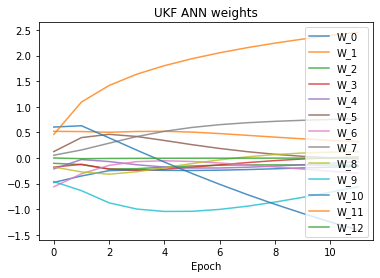

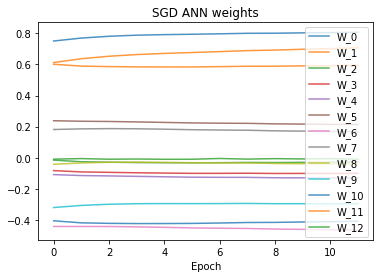

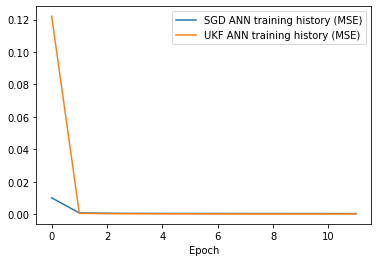

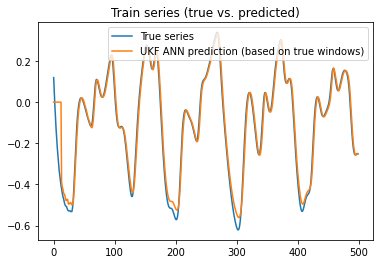

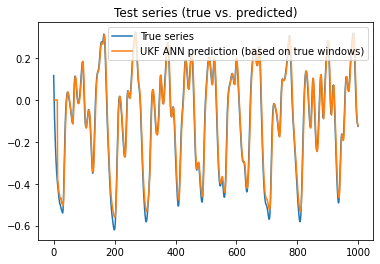

In [54]:
import utility,ukf
def main():
    utility.setup_logging('output')
    logging.info('Experiment parameters below')
    logging.info('\n{}'.format(pformat(params.__dict__)))

    window = params.window_size

    dt = 0.01
    n_samples = params.train_series_length

    X_series = utility.mackey_glass(sample_len=n_samples, tau=params.mg_tau, n_samples=window)
    X_series = np.array(X_series[0]).reshape((n_samples))

    params.X_data, params.y_data = prepare_dataset(X_series, window, stride=1)

    params.hxw_model = create_neural_net(window)
    w_init = get_weights_vector(params.hxw_model)
    num_weights = w_init.shape[0]

    P_init = 0.1 * np.eye(num_weights)  # Initial values of covariance matrix of state variables (MxM)
    Q = params.Q_var * np.eye(num_weights)  # Process noise covariance matrix (MxM)
    R = np.array([[params.R_var]])  # Measurement noise covariance matrix (DxD)

    sgd_ann = create_neural_net(window)
    sgd_ann.set_weights(params.hxw_model.get_weights())  # Same starting point as the UKF_ANN

    ukf_ann = create_neural_net(window)
    ukf_ann.set_weights(params.hxw_model.get_weights())  # Same starting point as the UKF_ANN

    z_true_series = params.y_data
    num_iter = params.epochs * len(z_true_series)

    # 2 Kalman filter implementations to compare (from filterpy and my custom impl)
    ukf_filter = create_ukf(Q, R, dt, w_init, P_init)
    my_ukf = create_my_ukf(Q, R, dt, w_init, P_init)

    # Pre-allocate output variables
    ukf_w = np.zeros((num_weights, params.epochs))
    my_ukf_w = np.zeros((num_weights, params.epochs))
    ukf_train_mse = np.zeros(params.epochs)
    my_ukf_train_mse = np.zeros(params.epochs)
    sgd_train_mse = np.zeros(params.epochs)

    # -------------------------------------------
    # Training loop with UKF

    logging.info("Training neural net with UKF")
    t0 = time.time()
    epoch = 0

    for i in range(num_iter):
        idx = i % len(z_true_series)
        # logging.info(idx)
        if idx == 0:
            if not params.train_ukf_ann:
                break

            preds = ukf_ann.predict(params.X_data)
            mse = mean_squared_error(z_true_series, preds)
            ukf_train_mse[epoch] = mse
            my_ukf_train_mse[epoch] = mse

            ukf_w[:, epoch] = ukf_filter.x[:]
            my_ukf_w[:, epoch] = my_ukf.x[:]

            epoch += 1
            #logging.info('Epoch: {} / {}'.format(epoch, params.epochs))

        params.curr_idx = idx  # For use in hw() to fetch correct x_k sample

        # Time update (state prediction according to F, Q
        ukf_filter.predict()
        #my_ukf.predict()

        # Measurement update (innovation) according to observed z, H, R
        z = z_true_series[idx]
        ukf_filter.update(z)
        #my_ukf.update(z)

        set_weights(params.hxw_model, ukf_filter.x)
        set_weights(ukf_ann, ukf_filter.x)

        # filter.x has shape Mx1
        # ukf_w[:, i] = ukf_filter.x[:]
        # my_ukf_w[:, i] = my_ukf.x[:]

    time_to_train = time.time() - t0
    logging.info('Training complete. time_to_train = {:.2f} sec, {:.2f} min'.format(time_to_train, time_to_train / 60))

    # -------------------------------------------
    # Train SGD ANN (for comparison)
    logging.info("Training neural net with SGD")
    info_tracker = EpochInfoTracker()
    callbacks = [info_tracker]
    history = sgd_ann.fit(params.X_data, params.y_data, batch_size=1, epochs=params.epochs, verbose=3,
                          callbacks=callbacks)
    logging.info('Training SGD complete')

    # -------------------------------------------
    # Results analysis

    # Visualize evolution of ANN weights
    sgd_ann_w = np.array(info_tracker.weights_history).T

    logging.info('Visualize evolution of UKF ANN weights')

    x_var = range(params.epochs)
    utility.plot(x_var, ukf_w[0, :], xlabel='Epoch', title='UKF ANN weights', label='W_0', alpha=0.8)
    for j in range(1, ukf_w.shape[0]):
        utility.plot(x_var, ukf_w[j, :], new_figure=False, label='W_' + str(j), alpha=0.8)

    logging.info('Visualize evolution of SGD ANN weights')

    x_var = range(params.epochs)
    utility.plot(x_var, sgd_ann_w[0, :], xlabel='Epoch', title='SGD ANN weights', label='W_0', alpha=0.8)
    for j in range(1, sgd_ann_w.shape[0]):
        utility.plot(x_var, sgd_ann_w[j, :], new_figure=False, label='W_' + str(j), alpha=0.8)

    # Visualize evolution of true y vs. hxw(x,w)
    logging.info('Visualize evolution of true y vs. hxw(x,w)')

    # Visualize error curve (SGD vs UKF)
    x_var = range(params.epochs)
    hist = history.history['loss']
    utility.plot(x_var, hist, xlabel='Epoch', label='SGD ANN training history (MSE)')
    utility.plot(x_var, ukf_train_mse, new_figure=False, label='UKF ANN training history (MSE)')

    # True test series vs. ANN pred vs, UKF pred
    logging.info('Evaluating and visualizing neural net predictions')
    evaluate_neural_nets(sgd_ann, ukf_ann, window, use_train_series=True, train_series=X_series)
    evaluate_neural_nets(sgd_ann, ukf_ann, window)

    utility.save_all_figures('output')
    plt.show()


if __name__ == "__main__":
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # This line disables GPU
    main()